In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [86]:
niftybees = yf.download("NIFTYBEES.BO", start="2000-01-01", end="2025-01-09", interval="1mo")
goldbees = yf.download("GOLDBEES.BO", start="2000-01-01", end="2025-01-09", interval="1mo")

# Ensure only monthly closing prices are kept
niftybees = niftybees["Adj Close"]['NIFTYBEES.BO']
goldbees = goldbees["Adj Close"]['GOLDBEES.BO']['2010-03-01':]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [91]:
data = pd.concat([niftybees, goldbees], axis=1).dropna()

data.columns = ["NIFTYBEES", "GOLDBEES"]

# data['lagged_1_year_avg_pe'] = data['P/E'].rolling(12).mean()

# data = data['2014-11-01':'2021-03-01']

data["NIFTYBEES_Return"] = data["NIFTYBEES"].pct_change()
data["GOLDBEES_Return"] = data["GOLDBEES"].pct_change()

data['lagged_2_mo_nifty'] = data['NIFTYBEES'].shift(1)/data['NIFTYBEES'].shift(3)
data['lagged_8_mo_nifty'] = data['NIFTYBEES'].shift(1)/data['NIFTYBEES'].shift(9)

data = data.iloc[10:]


# Generate signals
data["Signal"] = np.where((data['lagged_2_mo_nifty'] > 1) | (data['lagged_8_mo_nifty'] > 1), "NIFTYBEES", "GOLDBEES")

# Calculate returns

data["Strategy_Return"] = np.where(
    data["Signal"] == "NIFTYBEES", data["NIFTYBEES_Return"], data["GOLDBEES_Return"]
    )

In [92]:
data.head(10)

,NIFTYBEES,GOLDBEES,NIFTYBEES_Return,GOLDBEES_Return,lagged_2_mo_nifty,lagged_8_mo_nifty,Signal,Strategy_Return
Date,,,,,,,,
2011-01-01,55.369999,19.558701,-0.105420,-0.026688,1.028156,1.181090,NIFTYBEES,-0.105420
2011-02-01,54.160000,20.194599,-0.021853,0.032512,0.927471,1.093620,NIFTYBEES,-0.021853
2011-03-01,58.340000,20.228300,0.077179,0.001669,0.875030,1.016612,NIFTYBEES,0.077179
2011-04-01,58.060001,21.558901,-0.004799,0.065779,1.053639,1.076582,NIFTYBEES,-0.004799
2011-05-01,56.340000,21.902599,-0.029625,0.015942,1.072009,1.077180,NIFTYBEES,-0.029625
2011-06-01,57.290001,21.349100,0.016862,-0.025271,0.965718,0.937438,GOLDBEES,-0.025271
2011-07-01,55.709999,22.317200,-0.027579,0.045346,0.986738,0.951661,GOLDBEES,0.045346
2011-08-01,51.200001,25.909901,-0.080955,0.160984,0.988818,0.933166,GOLDBEES,0.160984
2011-09-01,50.320000,25.188299,-0.017188,-0.027850,0.893699,0.827207,GOLDBEES,-0.027850


Performance Metrics:
Sharpe Ratio: 0.97
Max Drawdown: -0.16
Cumulative Return: 6.15


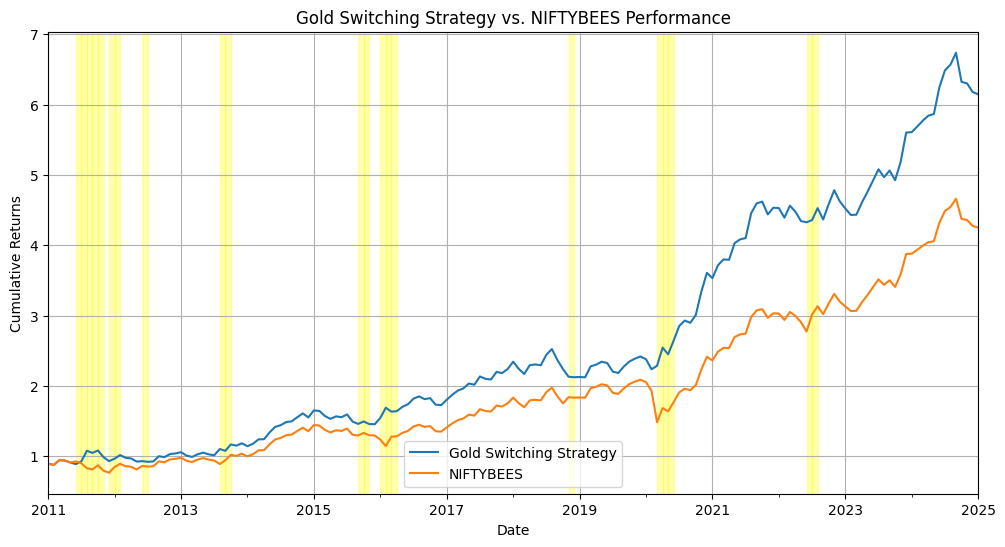

In [94]:
# Plot performance
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative returns
data[["Cumulative_Strategy", "Cumulative_NIFTYBEES"]].plot(ax=ax)

# Add coloring based on the 'Signal' column
for i in range(len(data) - 1):
    if data.iloc[i]["Signal"] == "GOLDBEES":
        ax.axvspan(data.index[i], data.index[i + 1], color="yellow", alpha=0.3)

# Add title, labels, legend, and grid
plt.title("Gold Switching Strategy vs. NIFTYBEES Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(["Gold Switching Strategy", "NIFTYBEES"])
plt.grid()
plt.show()

In [111]:
risk_free = pd.read_csv("risk_free_rate_india.csv")
data['risk_free'] = risk_free['Price'].values * 0.01 / 12
data

,NIFTYBEES,GOLDBEES,NIFTYBEES_Return,GOLDBEES_Return,lagged_2_mo_nifty,lagged_8_mo_nifty,Signal,Strategy_Return,Cumulative_Strategy,Cumulative_NIFTYBEES,risk_free
Date,,,,,,,,,,,
2011-01-01,55.369999,19.558701,-0.105420,-0.026688,1.028156,1.181090,NIFTYBEES,-0.105420,0.894580,0.894580,0.005637
2011-02-01,54.160000,20.194599,-0.021853,0.032512,0.927471,1.093620,NIFTYBEES,-0.021853,0.875030,0.875030,0.005633
2011-03-01,58.340000,20.228300,0.077179,0.001669,0.875030,1.016612,NIFTYBEES,0.077179,0.942564,0.942564,0.005625
2011-04-01,58.060001,21.558901,-0.004799,0.065779,1.053639,1.076582,NIFTYBEES,-0.004799,0.938040,0.938040,0.005700
2011-05-01,56.340000,21.902599,-0.029625,0.015942,1.072009,1.077180,NIFTYBEES,-0.029625,0.910251,0.910251,0.005625
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,288.489990,63.540001,0.025815,0.047823,1.051406,1.172476,NIFTYBEES,0.025815,6.737449,4.660958,0.007009
2024-10-01,270.730011,66.919998,-0.061562,0.053195,1.038780,1.201341,NIFTYBEES,-0.061562,6.322679,4.374021,0.006779
2024-11-01,269.809998,64.290001,-0.003398,-0.039301,0.962664,1.111691,NIFTYBEES,-0.003398,6.301193,4.359157,0.006654


In [113]:
# Sharpe ratio
sharpe_ratio_n = (data["NIFTYBEES_Return"] - data['risk_free']).mean() / (data["NIFTYBEES_Return"] - data['risk_free']).std() * np.sqrt(12)

# Maximum drawdown
rolling_max_n = data["Cumulative_NIFTYBEES"].cummax()
drawdown_n = (data["Cumulative_NIFTYBEES"] - rolling_max_n) / rolling_max_n
max_drawdown_n = drawdown_n.min()

# Performance metrics
performance_n = {
    "Sharpe Ratio": sharpe_ratio_n*np.sqrt(12),
    "Max Drawdown": max_drawdown_n,
    "Cumulative Return": data["Cumulative_NIFTYBEES"].iloc[-1]
}


data["Cumulative_Strategy"] = (1 + data["Strategy_Return"]).cumprod()
data["Cumulative_NIFTYBEES"] = (1 + data["NIFTYBEES_Return"]).cumprod()

# Sharpe ratio
sharpe_ratio = (data["Strategy_Return"] - data['risk_free']).mean() / (data["Strategy_Return"] - data['risk_free']).std() * np.sqrt(12)

# Maximum drawdown
rolling_max = data["Cumulative_Strategy"].cummax()
drawdown = (data["Cumulative_Strategy"] - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Performance metrics
performance = {
    "Sharpe Ratio": sharpe_ratio*np.sqrt(12),
    "Max Drawdown": max_drawdown,
    "Cumulative Return": data["Cumulative_Strategy"].iloc[-1]
}

print("Performance Metrics NIFTY:")
for metric, value in performance_n.items():
    print(f"{metric}: {value:.2f}")

print("\n")
# Print results
print("Performance Metrics:")
for metric, value in performance.items():
    print(f"{metric}: {value:.2f}")

Performance Metrics NIFTY:
Sharpe Ratio: 0.92
Max Drawdown: -0.29
Cumulative Return: 4.25


Performance Metrics:
Sharpe Ratio: 1.59
Max Drawdown: -0.16
Cumulative Return: 6.15


In [114]:
data["Strategy_Return"] - data['risk_free']

Date
2011-01-01   -0.111057
2011-02-01   -0.027485
2011-03-01    0.071554
2011-04-01   -0.010499
2011-05-01   -0.035250
                ...   
2024-09-01    0.018806
2024-10-01   -0.068341
2024-11-01   -0.010052
2024-12-01   -0.026081
2025-01-01   -0.011968
Length: 169, dtype: float64